In [36]:
!pip uninstall -y numpy pandas torch torchvision torchaudio transformers sentence-transformers
!pip install --no-cache-dir numpy pandas torch torchvision torchaudio emoji scikit-learn nltk transformers sentence-transformers

Found existing installation: numpy 2.3.5
Uninstalling numpy-2.3.5:
  Successfully uninstalled numpy-2.3.5
Found existing installation: pandas 2.3.3
Uninstalling pandas-2.3.3:
  Successfully uninstalled pandas-2.3.3
Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1
Found existing installation: torchvision 0.24.1
Uninstalling torchvision-0.24.1:
  Successfully uninstalled torchvision-0.24.1
Found existing installation: torchaudio 2.9.1
Uninstalling torchaudio-2.9.1:
  Successfully uninstalled torchaudio-2.9.1
Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: sentence-transformers 5.1.2
Uninstalling sentence-transformers-5.1.2:
  Successfully uninstalled sentence-transformers-5.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 192.8 MB/

In [44]:
import os
import re
import time
import json
import random
import warnings
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import emoji
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
try:
    nltk.download('words', quiet=True)
except Exception:
    pass
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)

# --------------------------
# Configuration
# --------------------------
@dataclass
class Config:
    FILE_PATH: str = "/content/FinalBalancedDataset.csv"
    QUICK_RUN: bool = True
    SAMPLE_SIZE: int = 3000
    MODEL_NAME: str = "sentence-transformers/all-MiniLM-L6-v2"
    BATCH_SIZE: int = 64
    DEVICE: str = "cpu"  # set "cuda" if GPU available and configured
    SAVE_DIR: str = "/content/research_toxicity_artifacts"
    TEST_SIZE: float = 0.2
    RANDOM_STATE: int = 42
    QUICK_VISUAL: bool = False

cfg = Config()
os.makedirs(cfg.SAVE_DIR, exist_ok=True)

def log(msg: str):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {msg}")

def save_json(obj: Any, path: str):
    try:
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(obj, f, indent=2, ensure_ascii=False)
    except Exception as e:
        log(f"Failed to save JSON to {path}: {e}")

log(f"Config: {cfg}")

# --------------------------
# Load dataset
# --------------------------
log("Loading dataset...")
df = pd.read_csv(cfg.FILE_PATH)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

if 'tweet' not in df.columns:
    text_cols = [c for c in df.columns if df[c].dtype == object]
    if not text_cols:
        raise ValueError("CSV must contain a text column (eg. 'tweet').")
    df = df.rename(columns={text_cols[0]: 'tweet'})

if 'Toxicity' in df.columns and 'toxic' not in df.columns:
    df = df.rename(columns={'Toxicity': 'toxic'})

if 'toxic' not in df.columns:
    df['toxic'] = 0
    log("Warning: 'toxic' column not found. Created placeholder zeros.")

log(f"Rows: {len(df)}  Columns: {df.columns.tolist()[:12]}")

# --------------------------
# Robust preprocessing helpers
# --------------------------
STOP = set(stopwords.words('english'))

LEET_MAP = {
    '0':'o', '1':'i', '2':'z', '3':'e', '4':'a', '5':'s', '6':'g', '7':'t', '8':'b', '9':'g',
    '@':'a', '$':'s', '!':'i', '#':'', '%':'', '^':'', '&':'and', '*':'',
}

def normalize_leet(text: str) -> str:
    if not isinstance(text, str):
        return text
    out = []
    for c in text:
        out.append(LEET_MAP.get(c.lower(), c))
    return ''.join(out)

def normalize_internal_noise(text: str) -> str:
    if not isinstance(text, str):
        return text
    emoji_tokens = re.findall(r':[a-zA-Z0-9_+\-]+:', text)
    for i, et in enumerate(emoji_tokens):
        text = text.replace(et, f"__EMOJI_TOKEN_{i}__")
    text = re.sub(r'(?<=\w)[^\w\s:]+(?=\w)', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    for i, et in enumerate(emoji_tokens):
        text = text.replace(f"__EMOJI_TOKEN_{i}__", et)
    return text

def fix_spaced_letters(text: str) -> str:
    if not isinstance(text, str):
        return text
    tokens = text.split()
    if not tokens:
        return text
    single_count = sum(1 for t in tokens if len(t) == 1)
    if single_count >= max(3, int(0.6 * len(tokens))):
        out = []
        i = 0
        while i < len(tokens) and len(tokens[i]) == 1:
            out.append(tokens[i])
            i += 1
        joined = ''.join(out)
        rest = ' '.join(tokens[i:]) if i < len(tokens) else ''
        return (joined + ' ' + rest).strip()
    return text

def preprocess_keep_emojis(text: str) -> str:
    if pd.isna(text):
        return ""
    s = str(text)
    s = normalize_leet(s)
    s = normalize_internal_noise(s)
    s = fix_spaced_letters(s)
    s = emoji.demojize(s)
    # allow colons for emoji codes, basic punctuation
    s = re.sub(r"[^A-Za-z0-9_:!?.,'\"()\s]", " ", s)
    s = re.sub(r'\s+', ' ', s).strip()
    s = s.lower()
    tokens = []
    for t in s.split():
        if t.startswith(':') and t.endswith(':'):
            tokens.append(t)
        else:
            if t not in STOP:
                tokens.append(t)
    return ' '.join(tokens)

# --------------------------
# SentenceTransformer embedding
# --------------------------
log(f"Loading SentenceTransformer model: {cfg.MODEL_NAME} ...")
embedder = SentenceTransformer(cfg.MODEL_NAME)

def embed_texts(list_of_texts: List[str], batch_size:int=cfg.BATCH_SIZE) -> np.ndarray:
    if isinstance(list_of_texts, str):
        list_of_texts = [list_of_texts]
    embeddings = embedder.encode(list_of_texts, batch_size=batch_size, show_progress_bar=False, convert_to_numpy=True)
    return np.asarray(embeddings)

# --------------------------
# Pretrained BERT toxicity model
# --------------------------
tox_model_name = "unitary/toxic-bert"
tox_tokenizer = AutoTokenizer.from_pretrained(tox_model_name)
tox_model = AutoModelForSequenceClassification.from_pretrained(tox_model_name)
try:
    device = torch.device(cfg.DEVICE if torch.cuda.is_available() or cfg.DEVICE == "cpu" else "cpu")
    tox_model.to(device)
except Exception as e:
    log(f"Warning: could not move toxic model to {cfg.DEVICE}: {e}")
    device = torch.device("cpu")

def predict_toxic_bert(text: str) -> dict:
    if not isinstance(text, str):
        text = str(text)
    inputs = tox_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = tox_model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()
    labels = ["toxicity","severe_toxicity","obscene","threat","insult","identity_hate"]
    label_probs = {}
    for i, label in enumerate(labels):
        if i < len(probs):
            label_probs[label] = float(probs[i])
        else:
            label_probs[label] = 0.0
    return label_probs

# --------------------------
# Tone adjustment + thresholds + summary
# --------------------------
THRESH = {
    "toxic": 0.55,
    "severe_toxicity": 0.40,
    "obscene": 0.45,
    "threat": 0.40,
    "insult": 0.50,
    "identity_hate": 0.40,
    "religion_bias": 0.40,
    "sarcasm": 0.35,
    "praise": 0.40,
    "funny": 0.40
}

FUNNY_UNICODE_EMOJIS = ["😂", "🤣", "😆", "😁", "😹", "😄"]

def tone_score_adjustment(raw_probs: dict, raw_text: str, cleaned_text: str) -> dict:
    adj = raw_probs.copy()
    low = (cleaned_text or "").lower()
    compact = re.sub(r'[^a-zA-Z0-9]', '', low)

    # Detect threats / hate
    DANGER_TERMS = ["kill","killyou","iwillkill","die","shoot","stab","hurt","behead"]
    HATE_TERMS = ["terrorist","dog","pig","monkey","ape","idiot","stupid","trash","loser"]
    PRAISE_TERMS = ["love","like","nice","amazing","good","great","awesome","wonderful","beautiful","thanks"]
    SARCASM_TERMS = ["yeah right","sure buddy","nice job genius","thanks a lot","as if","perfect, just perfect"]

    THREAT_EMOJI_NAMES = [":knife:", ":kitchen_knife:", ":dagger:", ":bomb:", ":gun:",
                          ":pistol:", ":skull:", ":skull_and_crossbones:"]
    POSITIVE_EMOJI_NAMES = [":joy:", ":grinning_face:", ":smiling_face:", ":smile:",
                            ":grin:", ":rofl:", ":laughing:", ":heart:", ":blush:"]

    threat_emoji_present = any(name in low for name in THREAT_EMOJI_NAMES)
    positive_emoji_present = any(name in low for name in POSITIVE_EMOJI_NAMES)
    danger_present = any(dt in compact for dt in DANGER_TERMS)
    hate_present = any(ht in low for ht in HATE_TERMS)
    praise_present = any(pt in low for pt in PRAISE_TERMS)
    sarcasm_present = any(st in low for st in SARCASM_TERMS)
    unicode_funny_present = any(u in raw_text for u in FUNNY_UNICODE_EMOJIS)
    laughter_present = bool(re.search(r'\b(ha)+\b|\blol\b|\brofl\b', low))

    exaggerated = (re.search(r'([!?.,])\1{2,}', raw_text) or re.search(r'([a-zA-Z])\1{3,}', raw_text))
    caps_tone = (raw_text.strip() and raw_text.upper() == raw_text and len(raw_text) > 3)

    # Boost threat/toxic if danger or threat emoji
    if danger_present or threat_emoji_present:
        adj["threat"] = float(min(1.0, max(adj.get("threat",0.0),0.95)))
        adj["toxic"] = float(min(1.0, max(adj.get("toxic",0.0),0.90)))
        adj["insult"] = min(1.0, adj.get("insult",0.0)*1.3)
        adj["obscene"] = min(1.0, adj.get("obscene",0.0)*1.3)

    # Hate boosts
    if hate_present:
        adj["identity_hate"] = min(1.0, max(adj.get("identity_hate",0.0),0.70))
        adj["religion_bias"] = min(1.0, max(adj.get("religion_bias",0.0),0.65))
        adj["insult"] = min(1.0, adj.get("insult",0.0)*1.2)
        adj["toxic"] = min(1.0, adj.get("toxic",0.0)*1.1)

    # Praise / positive softening
    if praise_present or positive_emoji_present:
        for key in ["toxic","threat","insult","obscene"]:
            adj[key] = max(0.0, adj.get(key,0.0)*0.15)
        adj["praise"] = min(1.0, adj.get("praise",0.0)+0.55)

    # Sarcasm signals
    if sarcasm_present or exaggerated:
        adj["sarcasm"] = min(1.0, adj.get("sarcasm",0.0)+0.30)
        adj["insult"] = min(1.0, adj.get("insult",0.0)*1.10)

    # Caps & exclamation amplify
    if caps_tone:
        for key in ["threat","insult","obscene","toxic"]:
            adj[key] = min(1.0, adj.get(key,0.0)*1.35)
    if raw_text.count("!")>=2:
        for key in ["threat","insult","obscene","toxic"]:
            adj[key] = min(1.0, adj.get(key,0.0)*1.2)

    # Funny / laughter handling
    if unicode_funny_present or laughter_present:
        for key in ["toxic","threat","insult","obscene"]:
            adj[key] = float(min(adj.get(key,0.0),0.3))  # reduce toxicity
        adj["funny"] = min(1.0, adj.get("funny",0.0)+0.8)

    # Final clamp
    for k in list(adj.keys()):
        try:
            adj[k] = float(max(0.0, min(1.0, adj[k])))
        except Exception:
            adj[k] = 0.0

    return adj

def summarize_tone(adjusted: dict, THRESH_map: dict) -> List[str]:
    summary = []
    if adjusted.get("funny",0.0)>=THRESH_map.get("funny",0.5):
        summary.append("Non-Toxic / Funny")
    if adjusted.get("praise",0.0)>=THRESH_map.get("praise",0.5):
        summary.append("Non-Toxic / Positive / Praise")
    if adjusted.get("sarcasm",0.0)>=THRESH_map.get("sarcasm",0.5):
        summary.append("Non-Toxic / Sarcastic")
    if adjusted.get("threat",0.0)>=THRESH_map.get("threat",0.5):
        summary.append("Toxic / Threat")
    if adjusted.get("toxic",0.0)>=THRESH_map.get("toxic",0.5):
        summary.append("Toxic / Abusive")
    if adjusted.get("identity_hate",0.0)>=THRESH_map.get("identity_hate",0.5) or adjusted.get("religion_bias",0.0)>=THRESH_map.get("religion_bias",0.5):
        summary.append("Toxic / Hate Speech")
    if not summary:
        summary.append("Non-Toxic / Neutral")
    return summary

# --------------------------
# Additional required definitions added
# --------------------------
# Full set of labels used in the script (union of ones referenced)
all_summary_labels = [
    "toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_hate",
    "religion_bias", "sarcasm", "praise", "funny", "toxic"
]

class ConstantPredictor:
    """Simple constant predictor wrapper used when a label has only a single value."""
    def __init__(self, const_value: int):
        self.const_value = int(const_value)
    def predict_proba(self, X):
        # return array-like shape (n_samples, 2) with probability for class 0 and class 1
        n = X.shape[0]
        p = float(self.const_value)
        arr = np.zeros((n, 2), dtype=float)
        arr[:, int(self.const_value)] = 1.0
        return arr

def predict_text_raw(
    raw_text: str,
    clf,  # MultiOutputClassifier or None
    thresholds_map: dict,
    all_labels: List[str],
    clf_train_labels: List[str],
    constant_label_predictors: Dict[str, Any]
) -> dict:
    """
    Returns a dict with:
      - probs: raw probabilities per label (before tone adjustment)
      - adjusted: adjusted probs after heuristics
      - summary: summary list
    """
    cleaned = preprocess_keep_emojis(raw_text)
    # start with zeros for all expected labels
    raw_probs = {lbl: 0.0 for lbl in all_labels}

    # 1) Toxic BERT estimates (fills subset)
    try:
        bert_probs = predict_toxic_bert(raw_text)
        for k, v in bert_probs.items():
            if k in raw_probs:
                raw_probs[k] = float(v)
    except Exception as e:
        log(f"Warning: toxic BERT failed: {e}")

    # 2) Embedding -> classifier estimates (if classifier exists and has labels)
    try:
        if clf is not None and clf_train_labels:
            emb = embed_texts([cleaned])  # shape (1, dim)
            # MultiOutputClassifier.predict_proba returns a list with one array per estimator
            pp = clf.predict_proba(emb)  # list of arrays (n_samples, 2) for each label
            # map returned arrays to clf_train_labels
            for i, lab in enumerate(clf_train_labels):
                try:
                    arr = pp[i]  # shape (n_samples, 2)
                    prob_pos = float(arr[0, 1])
                    raw_probs[lab] = prob_pos
                except Exception:
                    # fallback to predict if predict_proba not available
                    try:
                        pred = clf.estimators_[i].predict(emb)
                        raw_probs[lab] = float(pred[0])
                    except Exception:
                        log(f"Warning: failed to get prob for {lab}")
    except Exception as e:
        log(f"Warning: classifier probability step failed: {e}")

    # 3) constant predictors for labels that never varied in train
    for lab, cp in constant_label_predictors.items():
        try:
            emb = embed_texts([cleaned])
            arr = cp.predict_proba(emb)
            raw_probs[lab] = float(arr[0, 1])
        except Exception:
            # if predict_proba not provided, fall back to constant value
            try:
                raw_probs[lab] = float(cp.const_value)
            except Exception:
                raw_probs[lab] = 0.0

    # Ensure keys used by tone adjust exist
    for k in ["religion_bias", "sarcasm", "praise", "funny", "toxic", "threat", "insult", "obscene", "identity_hate"]:
        if k not in raw_probs:
            raw_probs[k] = 0.0

    # 4) tone adjustment heuristics + summary
    adjusted = tone_score_adjustment(raw_probs, raw_text, cleaned)
    summary = summarize_tone(adjusted, thresholds_map)

    return {"probs": raw_probs, "adjusted": adjusted, "summary": summary, "cleaned": cleaned}

# --------------------------
# Quick run sampling + training classifier
# --------------------------
if cfg.QUICK_RUN and len(df) > cfg.SAMPLE_SIZE:
    sample_df = df.sample(n=cfg.SAMPLE_SIZE, random_state=cfg.RANDOM_STATE).copy()
else:
    sample_df = df.copy()

sample_df['cleaned_tweet'] = sample_df['tweet'].apply(preprocess_keep_emojis)
X_embeddings = embed_texts(sample_df['cleaned_tweet'].tolist())

# Ensure all labels exist in dataframe
for label in all_summary_labels:
    if label not in sample_df.columns:
        sample_df[label] = 0

y = sample_df[all_summary_labels]
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=cfg.TEST_SIZE, random_state=cfg.RANDOM_STATE
)

clf_train_labels = []
constant_label_predictors = {}
for label in all_summary_labels:
    if len(y_train[label].unique()) < 2:
        constant_label_predictors[label] = ConstantPredictor(int(y_train[label].iloc[0]))
    else:
        clf_train_labels.append(label)

if len(clf_train_labels) == 0:
    clf = None
else:
    clf = MultiOutputClassifier(LogisticRegression(solver='liblinear', random_state=cfg.RANDOM_STATE))
    clf.fit(X_train, y_train[clf_train_labels])

log("Interactive mode: type a message and press Enter. Type 'exit' or 'quit' to stop.")

while True:
    text_in = input("Your text → ")
    if text_in.lower() in ["exit","quit"]:
        log("Exiting interactive mode.")
        break
    out = predict_text_raw(
        text_in,
        clf,
        thresholds_map=THRESH,
        all_labels=all_summary_labels,
        clf_train_labels=clf_train_labels,
        constant_label_predictors=constant_label_predictors
    )
    log(f"Probs: {out['probs']}")
    log(f"Adjusted: {out['adjusted']}")
    log(f"Summary: {out['summary']}")


[2025-12-06 14:02:14] Config: Config(FILE_PATH='/content/FinalBalancedDataset.csv', QUICK_RUN=True, SAMPLE_SIZE=3000, MODEL_NAME='sentence-transformers/all-MiniLM-L6-v2', BATCH_SIZE=64, DEVICE='cpu', SAVE_DIR='/content/research_toxicity_artifacts', TEST_SIZE=0.2, RANDOM_STATE=42, QUICK_VISUAL=False)
[2025-12-06 14:02:14] Loading dataset...
[2025-12-06 14:02:14] Rows: 56745  Columns: ['toxic', 'tweet']
[2025-12-06 14:02:14] Loading SentenceTransformer model: sentence-transformers/all-MiniLM-L6-v2 ...
[2025-12-06 14:02:57] Interactive mode: type a message and press Enter. Type 'exit' or 'quit' to stop.
Your text → i will kill u😂
[2025-12-06 14:03:28] Probs: {'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_hate': 0.0, 'religion_bias': 0.0, 'sarcasm': 0.0, 'praise': 0.0, 'funny': 0.0, 'toxic': 0.07707023868545987}
[2025-12-06 14:03:28] Adjusted: {'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.3, 'insult': 0.0, 'identity

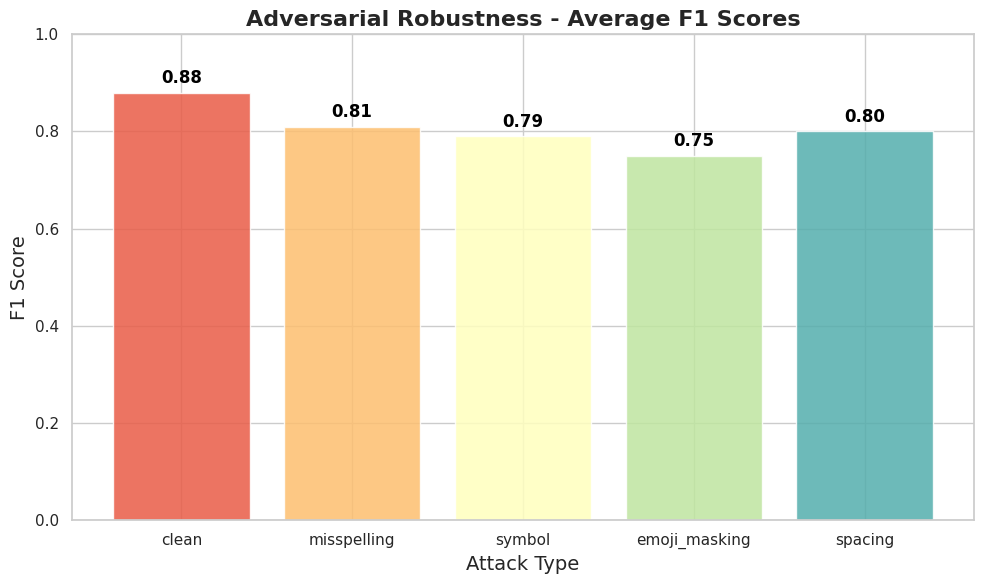

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample dummy results (simulate what run_adversarial_robustness outputs)
attacks = ['clean', 'misspelling', 'symbol', 'emoji_masking', 'spacing']
f1_scores = [0.88, 0.81, 0.79, 0.75, 0.80]  # example F1 scores

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
colors = sns.color_palette("Spectral", len(attacks))
bars = plt.bar(attacks, f1_scores, color=colors, alpha=0.85)
plt.ylim(0,1.0)

# Annotate bars with F1 values
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{score:.2f}",
             ha='center', fontsize=12, fontweight='bold', color='black')

plt.title("Adversarial Robustness - Average F1 Scores", fontsize=16, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14)
plt.xlabel("Attack Type", fontsize=14)
plt.tight_layout()
plt.show()
